In [57]:
import numpy as np
import soundfile as sf
import pandas as pd
import librosa
import glob
import matplotlib.pyplot as plt
from IPython.display import Audio
from notebook_utils import get_audio_list

In [78]:
clean_path = '/home/martin/deep-dereverb/data/prueba/clean/'
clean_list = get_audio_list(clean_path)
clean_list.sort()

reverb_path = '/home/martin/deep-dereverb/data/prueba/reverb/'
reverb_list = get_audio_list(reverb_path)
reverb_list.sort()

audio_list = [[clean_list[i], reverb_list[i]] for i in range(len(clean_list))]

In [15]:
clean, fs = sf.read(clean_list[0])
reverb, fs = sf.read(reverb_list[0])

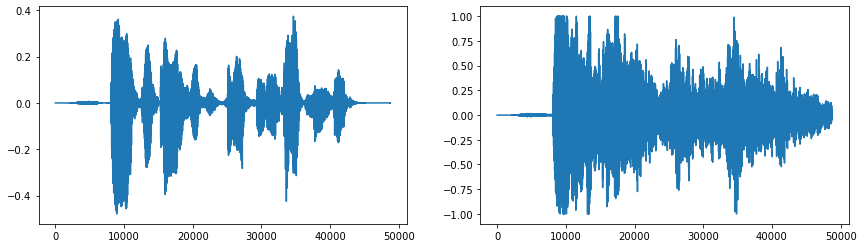

In [19]:
plt.subplot(1,2,1)
plt.plot(speech)
plt.subplot(1,2,2)
plt.plot(reverb)
plt.subplots_adjust(right=2)

In [25]:
Audio(clean, rate=16000)

In [24]:
Audio(reverb, rate=16000)

In [186]:
def audio_chunk(paths):
    """Recibe un path de audio y devuelve el path, los puntos de comienzo y final
    para recortar el audio, y la frecuencia de sampleo."""
    
    clean_path = paths[0]
    reverb_path = paths[1]
    
    #sin overlap
    win_size = int(32640) #no esta dependiendo de fs
    hop_size = int(32640) #en frames
    
    nframes = sf.info(clean_path, verbose = True).frames
    
    start = np.array(range(0,nframes-win_size,hop_size), dtype='int32')
    end = start + win_size
    return  clean_path, reverb_path, start, end

In [187]:
clean_path = '/home/martin/deep-dereverb/data/prueba/clean/'
clean_list = get_audio_list(clean_path)
clean_list.sort()

reverb_path = '/home/martin/deep-dereverb/data/prueba/reverb/'
reverb_list = get_audio_list(reverb_path)
reverb_list.sort()

audio_list = [[clean_list[i], reverb_list[i]] for i in range(len(clean_list))]

dicts = [{'clean_path':audio[0],'reverb_path':audio[1],'start': audio[2],'end':audio[3]} \
         for audio in map(audio_chunk, audio_list)]
 
df_speech = pd.concat(map(pd.DataFrame, dicts), axis=0, ignore_index = True)

In [188]:
def speech_dataframe(clean_path, reverb_path):
    clean_path = '/home/martin/deep-dereverb/data/prueba/clean/'
    clean_list = get_audio_list(clean_path)
    clean_list.sort()

    reverb_path = '/home/martin/deep-dereverb/data/prueba/reverb/'
    reverb_list = get_audio_list(reverb_path)
    reverb_list.sort()

    audio_list = [[clean_list[i], reverb_list[i]] for i in range(len(clean_list))]

    dicts = [{'clean_path':audio[0],'reverb_path':audio[1],\
              'start': audio[2],'end':audio[3]}\
             for audio in map(audio_chunk, audio_list)]
    df_speech = pd.concat(map(pd.DataFrame, dicts), axis=0, ignore_index = True)
    
    return df_speech

Para acceder a un elemento del dataset por el indice

In [189]:
indice = 100
elemento = 1 # 0->clena_path, 1->reverb_path, 2->start, 3->end
asd = df_speech.iat[indice, elemento]

# Dentro del DataGenerator

In [190]:
EPS = np.finfo(float).eps
def normalise(array):
    norm_array = (array - array.min()) / (array.max() - array.min() + EPS)
    return norm_array

In [191]:
ID = 0
dataframe = df_speech

In [192]:
clean_path = dataframe.iat[ID, 0]
reverb_path = dataframe.iat[ID, 1]
start, end = dataframe.iat[ID, 2], dataframe.iat[ID, 3]

clean, _ = sf.read(clean_path, start=start, stop=end)
reverb, _ = sf.read(reverb_path, start=start, stop=end)

#Genero las STFT
stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)[:-1,:]# Descarto altas frecuencias
stft_clean = np.abs(stft_clean)
stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)[:-1,:]
stft_reverb = np.abs(stft_reverb)

#Escala logaritmica
log_stft_clean = librosa.amplitude_to_db(stft_clean)
log_stft_reverb = librosa.amplitude_to_db(stft_reverb)

#Normalizacion
norm_stft_reverb = normalise(log_stft_reverb)
norm_stft_clean = normalise(log_stft_clean)


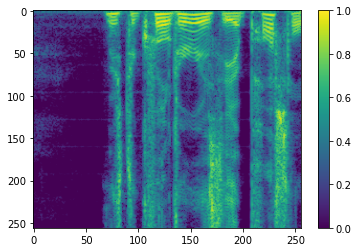

In [193]:
plt.imshow(norm_stft_clean, aspect='auto')
plt.colorbar()

In [194]:
norm_stft_clean.shape

(256, 256)

In [ ]:
def gen_stft(dataframe, ID):
    clean_path = dataframe.iat[ID, 0]
    reverb_path = dataframe.iat[ID, 1]
    start, end = dataframe.iat[ID, 2], dataframe.iat[ID, 3]

    clean, _ = sf.read(clean_path, start=start, stop=end)
    reverb, _ = sf.read(reverb_path, start=start, stop=end)

    #Genero las STFT
    stft_clean = librosa.stft(clean, n_fft=512, hop_length=128)[:-1,:]# Descarto altas frecuencias
    stft_clean = np.abs(stft_clean)
    stft_reverb = librosa.stft(reverb, n_fft=512, hop_length=128)[:-1,:]
    stft_reverb = np.abs(stft_reverb)

    #Escala logaritmica
    log_stft_clean = librosa.amplitude_to_db(stft_clean)
    log_stft_reverb = librosa.amplitude_to_db(stft_reverb)

    #Normalizacion
    norm_stft_reverb = normalise(log_stft_reverb)
    norm_stft_clean = normalise(log_stft_clean)
    return norm_stft_reverb, norm_stft_clean